In [3]:
import torch
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline 

In [4]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])


transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

In [5]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [6]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


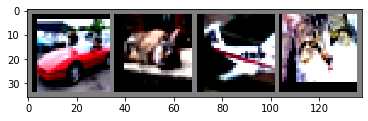

  car   cat plane   cat


In [7]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In such problems we are usually interested to take away the mean, and decorrelate the data (remove linear dependencies). 
This is done by transforming the data in such a way that its covariance matrix $\Sigma$ is the identity matrix. The process 
is called whitening and the Zero-phase Component Analysis (ZCA) is a widely used technique used for helping a deep 
learning model emphasize on the important features of an image. 

The covariance matrix for $N$ data points in $\mathbb{R}^n$ is denoted as $\Sigma \in \mathbb{R}^{n \times n}$ and is
equal to,

$\hat{\Sigma}_{jk} = \frac{1}{N-1} \sum_{i=1}^N (x_{ij} - \bar{x}_j) \cdot (x_{ik} - \bar{x}_k)$

where $\bar{x}_j$ denotes the j-th component of the estimated mean of the samples $x$. Any matrix 
$W \in \mathbb{R}^{n \times n}$ that satisfies $W^T W = C^{-1}$ will 'whiten' the data. ZCA is the choice 
$W = M^{- \frac{1}{2}}$. In their core, whitening techniques are a multiplication of the principal components with the 
data points $x$. The principal components are calculated using the following formula 
$[u \cdot \frac{1}{\sqrt{s + 10^{-7}}} I \cdot u^T]$, where $s \in \mathbb{R}^{n \times n}$ and 
$u \in \mathbb{R}^{n \times n}$ are obtained by performing singular value decomposition to the covariance matrix 
$\Sigma$. Or in short as implemented by 
[Keras](https://github.com/keras-team/keras/blob/master/keras/preprocessing/image.py#L670-L674 "Keras")

_ _ _

```python
# Calculate principal components
sigma = np.dot(flat_x.T, flat_x) / flat_x.shape[0]
u, s, _ = linalg.svd(sigma)
principal_components = np.dot(np.dot(u, np.diag(1. / np.sqrt(s + 10e-7))), u.T)

# Apply ZCA whitening
whitex = np.dot(flat_x, principal_components)
```
- - -

###### _for more information see [this][Krizhevsky] or [this][Agnan] paper or [this][StackOverflow] answer_

[Krizhevsky]: https://www.cs.toronto.edu/~kriz/learning-features-2009-TR.pdf "Learning Multiple Layers of Features from Tiny Images"
[Agnan]: https://arxiv.org/abs/1512.00809 "Optimal whitening and decorrelation"
[StackOverflow]: https://stats.stackexchange.com/questions/117427/what-is-the-difference-between-zca-whitening-and-pca-whitening "Answer on StackOverflow about ZCA"

In [1]:
from sklearn.decomposition import PCA

def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict
    
data_flat = np.vstack(tuple(unpickle("data/cifar-10-batches-py/data_batch_{}".format(n))[b'data'] for n in range(1, 6)))

pca = PCA(n_components=400, random_state=0, svd_solver='randomized')
pca.fit(data_flat)

# here we see the percentage of variance explained by just 400 components, out of the 32x32x3
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.ylim(0.8, 1.0)
plt.grid()


NameError: name 'np' is not defined

In [8]:
data_transformed = np.dot(data_flat - pca.mean_, pca.components_.T)

def reconstruct(pca, vec):
    return pca.mean_ + np.dot(vec, pca.components_)

def vtoimg(v):
     return np.array(np.clip(v, 0, 255), dtype=np.uint8).reshape(3, 32, 32).transpose([1, 2, 0])
    
image_index = 200    
original_image = data_flat[image_index].reshape(3,32,32).transpose([1,2,0])
reconstructed_image = vtoimg(reconstruct(pca, data_transformed[image_index]))

plt.subplot(1,2,1)
plt.imshow(original_image)
plt.subplot(1,2,2)
plt.imshow(reconstructed_image)

NameError: name 'dd' is not defined

We now need to remove the mean out of each image as well as any auto-correlation that is usually present ins such data.
If we rotate the data so as the principal direction found by PCA is now an axis we have in effect removed the 
correlation factor. The next step is to rescale the axes so as to normalize or whiten the data. For dataset with images
we expect strong auto-correlation, meaning that a pixel is usually not completely independent of its neighbouring 
pixels nor are the different color channels. So if we remove this correlation we end up with something that is closer to 
white noise, hence the term whitening. An intuitive way of thinking about it is that we construct a high-pass filter 
preserving only the information that makes an image different from a completely black or white image (similar to edge 
detection).

In [ ]:
def whiten(pca, vec):
    cor = np.dot(vec - pca.mean_, pca.components_.T)
    return np.dot(cor / pca.singular_values_, pca.components_) * np.sqrt(60000) * 64 + 128

whitened_image = vtoimg(whiten(pca, data_flat[image_index]))

plt.subplot(1,2,1)
plt.imshow(original_image)
plt.subplot(1,2,2)
plt.imshow(whitened_image)

In [ ]:
# auto-correlation accross different channels
dirac_r = pca.mean_.copy()
dirac_g = pca.mean_.copy()
dirac_b = pca.mean_.copy()

dirac_r[32*16+16] += 1
dirac_g[32*32+32*16+16] += 1
dirac_b[2*32*32+32*16+16] += 1

plt.plot(whiten(pca, dirac_r))
plt.plot(whiten(pca, dirac_g))
plt.plot(whiten(pca, dirac_b))

def vftoimg(v):
     return v.reshape(3,32,32).transpose([1,2,0])

kk = [dirac_r,dirac_g,dirac_b]
for k in range(3):
    for c in range(3):
        plt.subplot(3,3,c+1+k*3)
        # plt.imshow(vftoimg(whiten(pca, kk[k])-128)[:,:,c], cmap=plt.cm.coolwarm, vmin=-0.1, vmax=0.1)
        plt.imshow(vftoimg(whiten(pca, kk[k])-128)[:,:,c], cmap=plt.cm.coolwarm, vmin=-0.2, vmax=0.2)
        plt.xlim(13,19)
        plt.ylim(13,19)

In [ ]:
# We can now try to visualize the dataset in two dimensions

